In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [2]:
links_scientist = ['https://career.habr.com/vacancies?s[]=44&type=all']

links_analytic = ['https://career.habr.com/vacancies?page=1&s[]=43&type=all',
                  'https://career.habr.com/vacancies?page=2&s[]=43&type=all',
                  'https://career.habr.com/vacancies?page=3&s[]=43&type=all']

In [3]:
configurations = {
    "headers": {"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36"},
    "encoding": "utf-8",
    "timeout": 5,
    "should_verify_certificate": True,
    "headless_mode": True
}

In [4]:
class ParsedHabr:
  def __init__(self, link, configurations):
    self.links = link
    self.configurations = configurations
    self.data = {'date': [],
                 'company_name': [],
                 'specialization': [],
                 'vacancy': [],
                 'meta_information': [],
                 'level': [],
                 'required_skills': [],
                 'link_to_vacancy': []
                }

    self.levels = ['Младший (Junior)',
                   'Средний (Middle)',
                   'Старший (Senior)',
                   'Ведущий (Lead)']

  def parse_vacancies_page(self, soup):
    """
    Parsing vacancies from the link
    """
    all_section = soup.find_all("div", class_="vacancy-card")
    for element in all_section:
      date = element.find('div', class_="vacancy-card__date").get_text() # добавить дату с годом прям
      self.data['date'].append(date)

      company_name = element.find('div', class_="vacancy-card__company-title").get_text()
      self.data['company_name'].append(company_name)

      vacancy = element.find('div', class_="vacancy-card__title").find('a').get_text()
      self.data['vacancy'].append(vacancy)

      meta = self.get_meta(element)
      self.data['meta_information'].append(meta)

      specialization, level, skills = self.get_skills(element)
      self.data['specialization'].append(specialization)
      self.data['level'].append(level)
      self.data['required_skills'].append(skills)
      self.data['link_to_vacancy'].append(self.get_vacancy_link(element))

  @staticmethod
  def get_meta(element):
    """
    Get meta information,
    such as city, remote possibility etc
    """
    meta_info = element.find('div', class_="vacancy-card__meta").find_all('span')
    mets = []

    for el in meta_info:
      meta = el.get_text()
      if meta != ' • ':
        mets.append(meta)

    return ', '.join(mets)

  def get_skills(self, element):
    """
    Get specialization, level and required_skills
    """
    skills_list = element.find('div', class_="vacancy-card__skills").find_all('span')
    skill = []
    for el in skills_list:
      one_skill = el.get_text()
      if one_skill != ' • ':
        skill.append(one_skill)

    specialization = skill.pop(0)

    if skill[0] in self.levels:
      level = skill.pop(0)
    else:
      level = np.NaN

    return specialization, level, ', '.join(skill)

  @staticmethod
  def get_vacancy_link(element):
    """
    Get full link to vacancy
    """
    to_vacancies = 'https://career.habr.com'
    link_vac = element.find('div', class_="vacancy-card__title").find('a').get('href')

    return ''.join([to_vacancies, link_vac])

  def parse_pages(self):
    for link in self.links:
      response = requests.get(link,
                              self.configurations.get('headers'),
                              timeout=self.configurations.get('timeout'),
                              verify=self.configurations.get('should_verify_certificate'))
      soup = BeautifulSoup(response.text, 'lxml')
      self.parse_vacancies_page(soup)

  def get_dataframe(self):
    """
    Getting dataframe with all data
    """
    self.parse_pages()
    self.df = pd.DataFrame(self.data)
    return self.df

  def get_statistics(self):
    """
    Counting the number of different leveled vacancies
    """
    self.df.dropna().plot.pie(y='level')

In [5]:
parsed_scientists = ParsedHabr(links_scientist,
                               configurations)
scientists = parsed_scientists.get_dataframe()

In [6]:
parsed_analytics = ParsedHabr(links_analytic,
                               configurations)
analytics = parsed_analytics.get_dataframe()

In [225]:
with pd.ExcelWriter('parsing_results.xlsx') as writer:
    scientists.to_excel(writer, sheet_name='Scientists')
    analytics.to_excel(writer, sheet_name='Analytics')

# Analytics

In [7]:
import matplotlib.pyplot as plt


In [17]:
specializations = {
    'Ученый по данным': 'scientists',
    'Аналитик по данным': 'analytics'
}

In [96]:
def visualize_levels(df: pd.DataFrame):
  """
  Create a plot visualising number of different levels
  """
  level_counts = df['level'].value_counts()
  special = df['specialization'][0]
  plt.figure(figsize=(10, 5))
  level_counts.plot(kind='bar')
  special = df['specialization'][0]
  plt.title(f'Количество мест для вакансии "{special}"')
  plt.xlabel('Уровень')
  plt.ylabel('Количество')
  plt.xticks(rotation=0)
  plt.grid(axis='y', linestyle='--', linewidth=0.5)
  plt.savefig(f'levels_{specializations[special]}.png')
  plt.show()

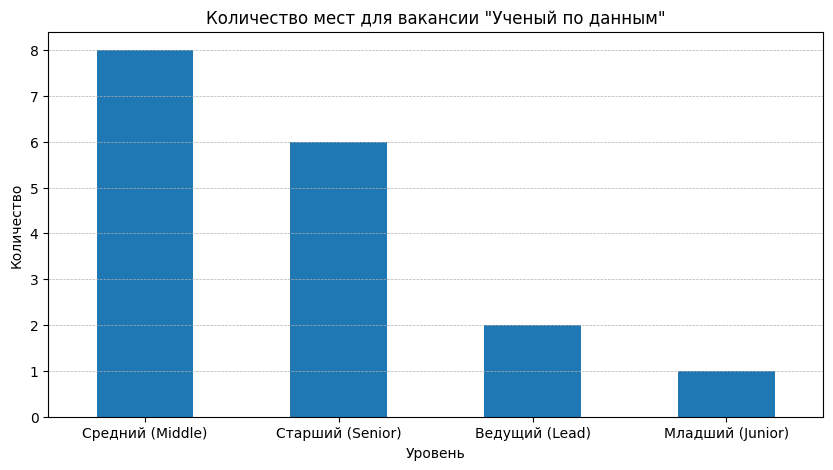

In [97]:
visualize_levels(scientists)

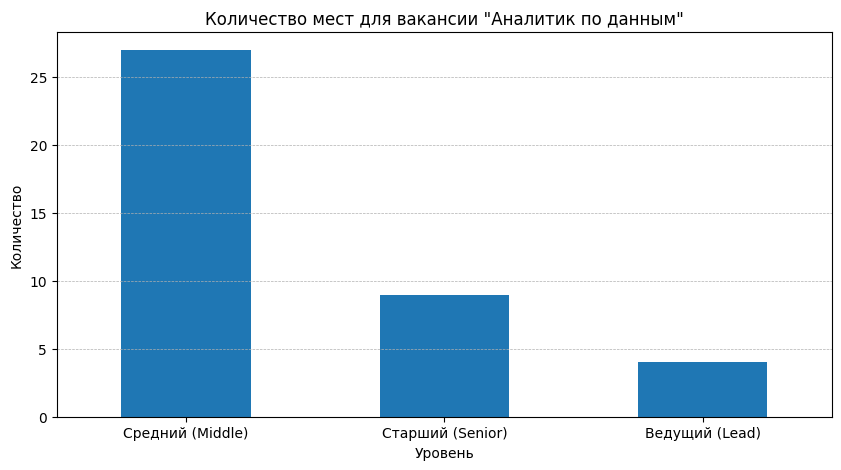

In [98]:
visualize_levels(analytics)

<Figure size 1500x3000 with 0 Axes>

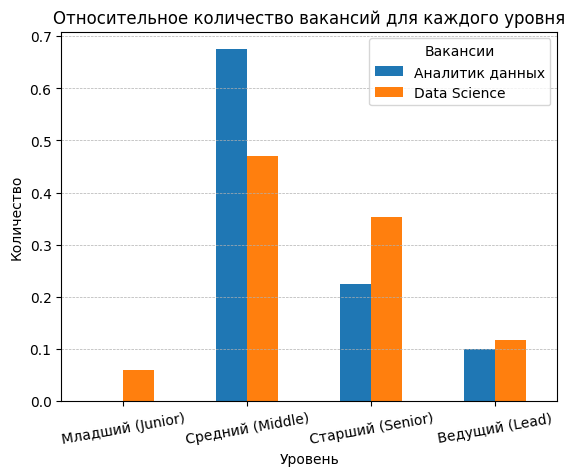

In [89]:
"""
Подсчет относительного количества вакансий
для каждого уровня для сравнения аналитиков и сайентистов
"""
level_counts_A = analytics['level'].value_counts()
relate_A = level_counts_A/sum(level_counts_A)
level_counts_S = scientists['level'].value_counts()
relate_S = level_counts_S/sum(level_counts_S)

all_levels = set(relate_A.index) | set(relate_S.index)
combined_counts = pd.DataFrame({
    'Аналитик данных': relate_A.reindex(all_levels, fill_value=0),
    'Data Science': relate_S.reindex(all_levels, fill_value=0)
})
combined_counts = combined_counts.reindex(parsed_analytics.levels)

plt.figure(figsize=(15, 30))
combined_counts.plot(kind='bar', linewidth=5)
plt.title('Относительное количество вакансий для каждого уровня')
plt.xlabel('Уровень')
plt.ylabel('Количество')
plt.xticks(rotation=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Вакансии', loc='upper right')
plt.savefig('comparison.png')
plt.show()

In [61]:
def by_levels(df):
  groupped = df.groupby('level')['specialization'].value_counts()
  result = pd.DataFrame(groupped.reset_index(name='number'))
  special = result['specialization'][0]
  result.drop('specialization', axis=1, inplace=True)
  result.columns = ['level', f'number_{specializations[special]}']
  return result

In [64]:
vacancies_s = by_levels(scientists)
vacancies_a = by_levels(analytics)

In [65]:
vacancies_merged = pd.merge(vacancies_s, vacancies_a, how='left')
vacancies_merged.fillna(0, inplace=True)
vacancies_merged['number_analytics'] = vacancies_merged.number_analytics.astype(int)

In [66]:
vacancies_merged

,level,number_scientists,number_analytics
0,Ведущий (Lead),2,4
1,Младший (Junior),1,0
2,Средний (Middle),8,27
3,Старший (Senior),6,9
